## How to create pyAPES forcing file?

Samuli Launiainen 2.7.2024

### We create here pyAPES forcing for Degerö Stormyr ICOS site 

- use ICOS data release

*Forcing variables; ascii-file, sep=';'*

- year: YYYY
- month: MM 
- day: dd 
- hour: hh 
- minute: mm 
- doy: decimal day of year
- Prec (kg m-2 30min-1): accumulated precipitation during timestep
- P (Pa): atm. pressure
- Tair (degC): air temperature
- U (m s-1): mean wind speed
- Ustar (m s-1): friction velocity (possible to run also with fixed U/Ustar -value) 
- H2O (Pa): vapor pressure
- CO2 (ppm): CO2 mixing ratio - here we assume 390.0 for 2011-2014 period as data was noisuy
- Zen (rad): solar zenith angle; one can use *pyAPES.microclimate.radiation.solar_angles* to compute. Double-check timestamps (timezone) so that Zen matches observed radiation cycles

*Radiation inputs:*
- LWin (W m-2) - incoming longwave radiation. Measured or can be estimated from atmospheric emissivity and near-surface air temperature
- diffPar, dirPar (W m-2): direct and diffuse Par 
- diffNir, dirNir (W m-2): direct and diffuse Nir 

We assume now 0.42 of measured global radiation is Par and 0.58 Nir, supported by site data (see below) and Proutsos et al. 2022. Atmospheric Research, 269.
As diffuse fraction was not measured, we estimate it from theoretical clear-sky radiation and observed global radiation (*pyAPES.microclimate.radiation.compute_clouds_rad*)

*For Planttype phenology* (optional, for intializing vascular plant LAI and relative photosynthetic capacity)
- DDsum (degC): temperature sum
- X (degC): stage of development (Kolari et al. 2009)

*Soil state (optional, for imposing soil boundary conditions)*
- SWC (m3m-3)
- Ts (degC)

In [1]:
# setting path
import sys
#sys.path.append('c:\\Repositories\\pyAPES_main')
import os
from dotenv import load_dotenv

load_dotenv()
pyAPES_main_folder = os.getenv('pyAPES_main_folder')

sys.path.append(pyAPES_main_folder)

#print(sys.path)

# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Read Degerö ICOS L2 data

- prepare model forcing
- prepare model evaluation dataset

https://fluxnet.org/data/fluxnet2015-dataset/variables-quick-start-guide/

In [2]:
ffile = r'C:\DATA\Fluxnet2015\SE-Deg\ICOSETC_SE-Deg_ARCHIVE_L2\ICOSETC_SE-Deg_FLUXNET_HH_L2.csv'
mfile = r'C:\DATA\Fluxnet2015\SE-Deg\ICOSETC_SE-Deg_ARCHIVE_L2\ICOSETC_SE-Deg_METEO_L2.csv'

raw = pd.read_csv(os.path.join(pyAPES_main_folder, ffile), sep=',', na_values=-9999)
t = pd.to_datetime(raw['TIMESTAMP_END'].astype(str))
raw.index = t

# select 2021->
raw = raw[raw.index > '2021-01-01 00:00:00']

met = pd.read_csv(os.path.join(pyAPES_main_folder, mfile), sep=',', na_values=-9999)
t = pd.to_datetime(met['TIMESTAMP_END'].astype(str))
met.index = t

# select 2021->
met = met[met.index > '2021-01-01 00:00:00']


In [3]:
cols = ['WD', 'USTAR', 'RH', 'NETRAD', 'PPFD_IN', 'PPFD_DIF', 'PPFD_OUT', 'SW_OUT', 'LW_OUT', 'CO2_F_MDS', 'TS_F_MDS_1', 'TS_F_MDS_2', 'TS_F_MDS_3', 'TS_F_MDS_4', 'TS_F_MDS_5', 'TS_F_MDS_6',
        'SWC_F_MDS_1', 'SWC_F_MDS_2', 'SWC_F_MDS_3', 'SWC_F_MDS_4', 'SWC_F_MDS_5',  'G_F_MDS', 'G_F_MDS_QC', 'LE_F_MDS', 'LE_F_MDS_QC', 'H_F_MDS', 'H_F_MDS_QC', ]

In [4]:
print(raw.columns.to_list())

['TIMESTAMP_START', 'TIMESTAMP_END', 'TA_F_MDS', 'TA_F_MDS_QC', 'TA_ERA', 'TA_F', 'TA_F_QC', 'SW_IN_POT', 'SW_IN_F_MDS', 'SW_IN_F_MDS_QC', 'SW_IN_ERA', 'SW_IN_F', 'SW_IN_F_QC', 'LW_IN_F_MDS', 'LW_IN_F_MDS_QC', 'LW_IN_ERA', 'LW_IN_F', 'LW_IN_F_QC', 'LW_IN_JSB', 'LW_IN_JSB_QC', 'LW_IN_JSB_ERA', 'LW_IN_JSB_F', 'LW_IN_JSB_F_QC', 'VPD_F_MDS', 'VPD_F_MDS_QC', 'VPD_ERA', 'VPD_F', 'VPD_F_QC', 'PA', 'PA_ERA', 'PA_F', 'PA_F_QC', 'P', 'P_ERA', 'P_F', 'P_F_QC', 'WS', 'WS_ERA', 'WS_F', 'WS_F_QC', 'WD', 'USTAR', 'RH', 'NETRAD', 'PPFD_IN', 'PPFD_DIF', 'PPFD_OUT', 'SW_OUT', 'LW_OUT', 'CO2_F_MDS', 'CO2_F_MDS_QC', 'TS_F_MDS_1', 'TS_F_MDS_2', 'TS_F_MDS_3', 'TS_F_MDS_4', 'TS_F_MDS_5', 'TS_F_MDS_6', 'TS_F_MDS_1_QC', 'TS_F_MDS_2_QC', 'TS_F_MDS_3_QC', 'TS_F_MDS_4_QC', 'TS_F_MDS_5_QC', 'TS_F_MDS_6_QC', 'SWC_F_MDS_1', 'SWC_F_MDS_2', 'SWC_F_MDS_3', 'SWC_F_MDS_4', 'SWC_F_MDS_5', 'SWC_F_MDS_1_QC', 'SWC_F_MDS_2_QC', 'SWC_F_MDS_3_QC', 'SWC_F_MDS_4_QC', 'SWC_F_MDS_5_QC', 'G_F_MDS', 'G_F_MDS_QC', 'LE_F_MDS', 'LE_F_MD

In [5]:
print(met.columns.to_list())

['TIMESTAMP_START', 'TIMESTAMP_END', 'TA', 'TA_1', 'TA_2', 'TA_3', 'TA_4', 'TA_5', 'RH', 'PA', 'SW_IN', 'SW_OUT', 'LW_IN', 'LW_OUT', 'PPFD_IN', 'PPFD_OUT', 'PPFD_DIF', 'D_SNOW', 'D_SNOW_SD', 'D_SNOW_N', 'G_1', 'G_1_SD', 'G_1_N', 'G_2', 'G_2_SD', 'G_2_N', 'SWC_1', 'SWC_1_SD', 'SWC_1_N', 'SWC_2', 'SWC_2_SD', 'SWC_2_N', 'SWC_3', 'SWC_3_SD', 'SWC_3_N', 'SWC_4', 'SWC_4_SD', 'SWC_4_N', 'SWC_5', 'SWC_5_SD', 'SWC_5_N', 'TS_1', 'TS_1_SD', 'TS_1_N', 'TS_2', 'TS_2_SD', 'TS_2_N', 'TS_3', 'TS_3_SD', 'TS_3_N', 'TS_4', 'TS_4_SD', 'TS_4_N', 'TS_5', 'TS_5_SD', 'TS_5_N', 'TS_6', 'TS_6_SD', 'TS_6_N', 'WTD', 'WTD_SD', 'WTD_N', 'ALB', 'NETRAD', 'P', 'VPD', 'WS', 'WD']


### Create output dataframe

In [6]:
forcing_outfile = os.path.join(pyAPES_main_folder, r'data\SE-Deg\SE-Deg_forcing.dat')
fluxes_outfile = os.path.join(pyAPES_main_folder, r'data\SE-Deg\SE-Deg_ICOS_subset.dat') 

fcols = ['year', 'month', 'day', 'hour', 'minute', 'doy',
         'Prec','P','Tair', 'U', 'Ustar', 'H2O', 'CO2', 
         'Zen', 'LWin', 'diffPar', 'dirPar', 'diffNir', 'dirNir',
         'DDsum', 'X', 'Tdaily', 'Tsoil', 'SWC']

forcing = pd.DataFrame(data=None, columns=fcols, index=raw.index)

forcing['year'] = raw.index.year
forcing['month'] = raw.index.month
forcing['day'] = raw.index.day
forcing['hour'] = raw.index.hour
forcing['minute'] = raw.index.minute
forcing['doy'] = raw.index.dayofyear

### Radiation variables

- use *pyAPES.microclimate.radiation.solar_angles* for zenith angle (Zen)
- use *pyAPES.microclimate.radiation.compute_clouds_rad* to estimate cloud cover, diffuse fraction and atm. emissivity
- LWin could be then computed as: *LWin = emi_atm * sigma * (Ta + DEG_TO_KELVIN)^4* 

In [7]:
from pyAPES.microclimate.radiation import solar_angles, compute_clouds_rad
from pyAPES.microclimate.micromet import e_sat

from pyAPES.utils.constants import DEG_TO_RAD, DEG_TO_KELVIN, PAR_TO_UMOL

fpar = 0.40 # ratio of Par/Global

Observed Par as function of Global radiation

Text(0, 0.5, 'PAR')

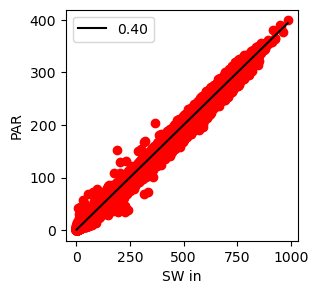

In [8]:
x = raw['SW_IN_F'].values
y = raw['PPFD_IN'].values / PAR_TO_UMOL
ix = np.where((x > 0) & (y >0))[0]

p = np.polyfit(x[ix], y[ix], 1)
fit = np.polyval(p, [0.0, max(x[ix])])

fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.plot(x[ix], y[ix], 'ro')
ax.plot([0.0, max(x[ix])], fit, 'k-', label='%.2f' %p[0])
ax.legend()
ax.set_xlabel('SW in'); ax.set_ylabel('PAR')


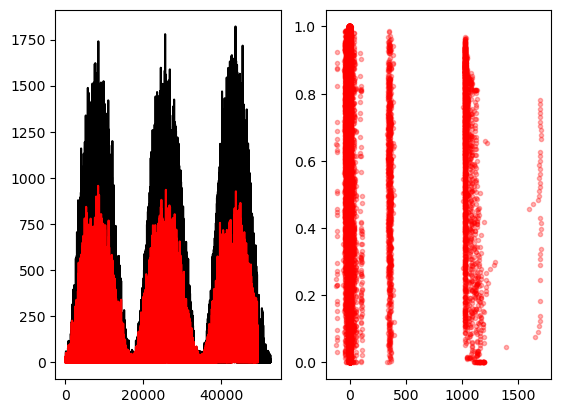

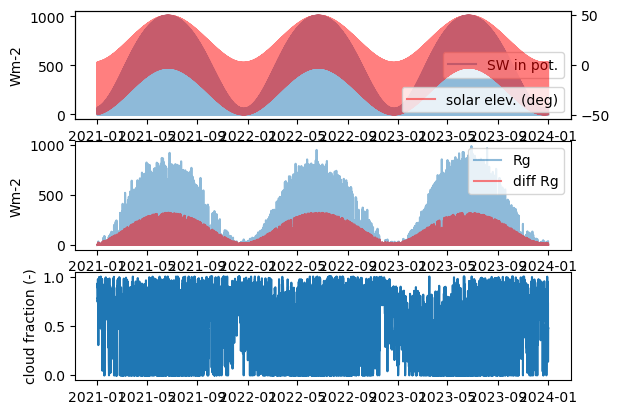

In [10]:
# compute solar angles
lat = 64.183 # N
lon = 19.55 # E
timeoffset = 1.15 # accounts for +1 UTC and 15min correction due to timestep being ENDTIME of 30min period

jday = forcing.index.dayofyear + forcing.index.hour / 24 + forcing.index.minute / (24*60)
jday = jday.values

# global radiation, air temperature, rh and air pressure are gap-filled in FluxNet2015 datarelease
rg = raw['SW_IN_F'].values # Wm-2
ta = raw['TA_F'].values # degC
es, _ = e_sat(ta) # saturation vapor pressure [Pa]

# rh is gappy, FluxNet2015 variable 'VPD_F' [hPa] is gap-filled
#rh = raw['RH'].values
#rh = np.maximum(1.0, np.minimum(rh, 100.0)) # make rh be in realistic range
#h2o = rh / 100 *es # vapor pressure [Pa]

vpd = 100 * raw['VPD_F'].values #[Pa]
h2o = es - vpd
rh = h2o / es
#rh = np.maximum(1.0, np.minimum(rh, 100.0)) # make rh be in realistic range
#h2o = rh / 100 *es # vapor pressure [Pa]

# compute solar zenit angle and estimate diffuse fraction
zen, azim, decl, sunrise, sunset, daylength = solar_angles(lat, lon, jday, timezone=timeoffset)
elev_angle = 90 - zen / DEG_TO_RAD

fcloud, fdiff, emi_sky = compute_clouds_rad(jday, zen, rg, h2o, ta)

# cloud fraction based on diffuse to total ppfd
ppfd_in = met['PPFD_IN'].values
ppfd_dif = met['PPFD_DIF'].values

ix = np.where((ppfd_in>50) & (ppfd_dif>0))[0]
fcloud0 = ppfd_dif / (ppfd_in + 0.001)
fcloud0[ix] = np.NaN

fig, ax = plt.subplots(1,2)
ax[0].plot(ppfd_in, 'k-')
ax[0].plot(ppfd_dif, 'r-')
ax[1].plot(fcloud0, fcloud, 'r.', alpha=0.3)

# plot 
#%matplotlib qt

t = raw.index

fig, ax = plt.subplots(3,1)
ax[0].plot(t, raw['SW_IN_POT'].values, '-', alpha=0.5, label='SW in pot.'), 
ax[0].legend()
ax[0].set_ylabel('Wm-2')
axb = ax[0].twinx()
axb.plot(t, elev_angle, 'r-', alpha=0.5, label='solar elev. (deg)')
axb.legend()

ax[1].plot(t, rg, '-', alpha=0.5, label='Rg')
ax[1].plot(t, fdiff * rg, 'r-', alpha=0.5, label='diff Rg')
ax[1].legend()
ax[1].set_ylabel('Wm-2')

ax[2].plot(t, fcloud, '-')
ax[2].set_ylabel('cloud fraction (-)')

# update forcing

forcing['Tair'] = ta
forcing['Prec'] = raw['P_F'].values
forcing['P'] = 1000 * raw['PA_F'].values # Pa
forcing['CO2'] = 390.0
forcing['H2O'] = 1000 * h2o / forcing['P'].values # mmol/mol = ppth
forcing['U'] = raw['WS_F'].values

forcing['Zen'] = zen
forcing['LWin'] = raw['LW_IN_F'].values
forcing['dirPar'] = fpar * (1 - fdiff) * rg
forcing['diffPar'] = fpar *  fdiff * rg
forcing['dirNir'] = (1 - fpar) * (1 - fdiff) * rg
forcing['diffNir'] = (1 - fpar) *  fdiff * rg

# soil temperature and moisture
ts = raw['TS_F_MDS_1'].interpolate('linear').values
swc = raw['SWC_F_MDS_2'].interpolate('linear').values
forcing['Tsoil'] = ts
forcing['SWC'] = swc

### wind speed and friction velocity: lot of spikes

J-P! Tämä jäi kesken; pitäisi miettiä fiksumpi tapa täyttää aukot!


In [19]:
from scipy import stats

def filter_binned(x, y, bins=20, lim=98.5):
    bin_lim, bin_edges, binnumber = stats.binned_statistic(x, y, statistic=lambda y: np.nanpercentile(y, lim), bins=bins)
    
    xl = bin_edges[0]
    xu = bin_edges[1]
    
    yout = y.copy()
    for j in range(0, len(bin_lim)):
        xl = bin_edges[j]
        xu = bin_edges[j+1]
        #print(j, xl, xu, bin_lim[j])
        ix = np.where((x>=xl) & (x<=xu))[0]
        yout[ix] = np.minimum(y[ix], bin_lim[j])

    return yout, bin_lim, bin_edges, binnumber

Friction velocity - fill gaps by linear interpolation

In [20]:
%matplotlib qt

fig, ax = plt.subplots(1,2, figsize=(8,4))

u = raw['WS_F'].copy()
ust_r = raw['USTAR'].copy()

# screen clear outliers
ix = np.where((u > 15 )| (ust_r > 0.8))[0]
u[ix] = np.NaN
ust_r[ix] = np.NaN
ix = np.where(u > 0)[0]
ax[0].hist(u[ix], 100)
#ax[0].set_xlim([0,30])

ix = np.where(ust_r > 0)[0]
ax[1].hist(ust_r[ix], 100)
ax[1].set_xlim([0,3])

fig, ax = plt.subplots(1,2, figsize=(8,4))

ax[0].plot(u, ust_r, 'k.')

ax[1].plot(u, 'k-')
ax[1].plot(ust_r, 'r.')

#--- remove outliers in WS bins

# store indices of finite data
ix = np.where((np.isfinite(u))| (np.isfinite(ust_r)))[0]
u0 = u[ix]
ust_r0 = ust_r[ix]

y, lims, binedges, binmeans = filter_binned(u0, ust_r0, bins=50, lim=99.0)
# copy back to right place in full vector
ust_r[ix] = y

ax[0].plot(u0, y, 'r.')

ix = np.where(np.isfinite(u))[0]
x = np.arange(0, len(u))
uf = np.interp(x, ix, u[ix])

# interpolate linearly
ix = np.where(np.isfinite(ust_r))[0]
yf = np.interp(x, ix, ust_r[ix])


forcing['Ustar'] = yf
forcing['U'] = uf


In [21]:
plt.figure()
plt.plot(u0, ust_r0, 'b.')
plt.plot(u0, y, 'r.')
plt.plot(uf, yf, 'g.')

fig, ax = plt.subplots(2,1)

ax[0].plot(forcing['U'], 'k.-')
ax[0].plot(u, 'r.-')
ax[1].plot(forcing['Ustar'], 'g.-')
ax[1].plot(y, 'r.')

Degree-day sum and phenology modifier
- from *pyAPES.planttype.phenology*

In [22]:

def degree_days(Tdaily, jday, Tbase=+5.0):
    N = len(Tdaily)
    y = np.zeros(N)
    
    for k in range(1, N):
        if jday[k] == 1:
            y[k] = 0.0
        else:
            y[k] = y[k-1] + np.max([Tdaily[k] - Tbase, 0.0])
    return y

def pheno_state(T, tau, x0 = 0.0):
    X = np.zeros(len(T)) + np.NaN
    X[0] = x0
    for k in range(1, len(X)):
        X[k] = X[k-1] + 1.0 / tau * (T[k] - X[k-1])  # degC
    return X

In [23]:
# Functions work on daily mean temperature
Tday = raw['TA_F'].resample('1D').mean()

doy = Tday.index.day_of_year

DDsum = degree_days(Tday.values, doy)
X = pheno_state(Tday.values, tau=8.0, x0=Tday[0])

tmp = pd.DataFrame(Tday)
tmp['DDsum'] = DDsum
tmp['X'] = X

# re-index and interpolate by forward-filling, except 1st day
tmp = tmp.reindex(index=raw.index)
tmp = tmp.ffill()
tmp = tmp.bfill()

# update forcing
forcing['Tdaily'] = tmp['TA_F'].values
forcing['DDsum'] = tmp['DDsum'].values
forcing['X'] = tmp['X'].values

### Plot forging variables & save to file

In [ ]:
%matplotlib qt

forcing = forcing[(forcing.index >= '2011-01-01')] # ignore 2010 as no soil temperature or moisture

for k in forcing.columns:
    plt.figure()
    plt.plot(forcing[k], label=k)
    gaps = len(np.where(np.isnan(forcing[k]))[0])
    plt.title(k + ' gaps: %d' %gaps)
    #plt.xlim(['2011-01-01', '2013-01-01'])
    plt.legend()

C:\Users\03081268\AppData\Local\Temp\ipykernel_16888\1718803178.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


In [ ]:
forcing[['year', 'month', 'day', 'hour', 'minute', 'doy']].astype(int)
forcing.to_csv(forcing_outfile, sep=';', float_format='%.3f', index=False)
plt.close('all')


### Take a look on snow data

In [28]:
met.columns

#plt.plot(met['D_SNOW'])


Index(['TIMESTAMP_START', 'TIMESTAMP_END', 'TA', 'TA_1', 'TA_2', 'TA_3',
       'TA_4', 'TA_5', 'RH', 'PA', 'SW_IN', 'SW_OUT', 'LW_IN', 'LW_OUT',
       'PPFD_IN', 'PPFD_OUT', 'PPFD_DIF', 'D_SNOW', 'D_SNOW_SD', 'D_SNOW_N',
       'G_1', 'G_1_SD', 'G_1_N', 'G_2', 'G_2_SD', 'G_2_N', 'SWC_1', 'SWC_1_SD',
       'SWC_1_N', 'SWC_2', 'SWC_2_SD', 'SWC_2_N', 'SWC_3', 'SWC_3_SD',
       'SWC_3_N', 'SWC_4', 'SWC_4_SD', 'SWC_4_N', 'SWC_5', 'SWC_5_SD',
       'SWC_5_N', 'TS_1', 'TS_1_SD', 'TS_1_N', 'TS_2', 'TS_2_SD', 'TS_2_N',
       'TS_3', 'TS_3_SD', 'TS_3_N', 'TS_4', 'TS_4_SD', 'TS_4_N', 'TS_5',
       'TS_5_SD', 'TS_5_N', 'TS_6', 'TS_6_SD', 'TS_6_N', 'WTD', 'WTD_SD',
       'WTD_N', 'ALB', 'NETRAD', 'P', 'VPD', 'WS', 'WD'],
      dtype='object')